In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                                                           | 0/50000 [00:00<?, ?it/s]

  8%|███████████▉                                                                                                                                 | 4235/50000 [00:00<00:01, 42347.82it/s]

 17%|████████████████████████▎                                                                                                                    | 8608/50000 [00:00<00:00, 43160.09it/s]

 26%|████████████████████████████████████▏                                                                                                       | 12925/50000 [00:00<00:00, 43017.68it/s]

 34%|████████████████████████████████████████████████▏                                                                                           | 17227/50000 [00:00<00:00, 43016.30it/s]

 43%|████████████████████████████████████████████████████████████▌                                                                               | 21625/50000 [00:00<00:00, 43361.31it/s]

 52%|████████████████████████████████████████████████████████████████████████▉                                                                   | 26046/50000 [00:00<00:00, 43647.14it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▏                                                      | 30430/50000 [00:00<00:00, 43707.20it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 34846/50000 [00:00<00:00, 43849.83it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 39247/50000 [00:00<00:00, 43899.27it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 43637/50000 [00:01<00:00, 43503.33it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 47989/50000 [00:01<00:00, 43229.89it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 43410.92it/s]

Files already downloaded and verified


  0%|                                                                                                                                                           | 0/10000 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████▋                                                                                 | 4229/10000 [00:00<00:00, 42279.25it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 8457/10000 [00:00<00:00, 41179.98it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 41086.83it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 blu3najq


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-blu3najq:best, 314.57MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:6.1


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                             | 0/157 [00:00<?, ?it/s]

  1%|▉                                                                                                                                                    | 1/157 [00:00<01:19,  1.97it/s]

  6%|█████████▍                                                                                                                                          | 10/157 [00:00<00:07, 20.97it/s]

 12%|█████████████████▉                                                                                                                                  | 19/157 [00:00<00:03, 36.80it/s]

 18%|███████████████████████████▎                                                                                                                        | 29/157 [00:00<00:02, 51.26it/s]

 24%|███████████████████████████████████▊                                                                                                                | 38/157 [00:00<00:01, 60.40it/s]

 30%|████████████████████████████████████████████▎                                                                                                       | 47/157 [00:01<00:01, 67.65it/s]

 36%|████████████████████████████████████████████████████▊                                                                                               | 56/157 [00:01<00:01, 73.36it/s]

 41%|█████████████████████████████████████████████████████████████▎                                                                                      | 65/157 [00:01<00:01, 77.57it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                              | 74/157 [00:01<00:01, 80.64it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▏                                                                     | 83/157 [00:01<00:00, 82.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                             | 92/157 [00:01<00:00, 84.50it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 101/157 [00:01<00:00, 85.58it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 110/157 [00:01<00:00, 86.30it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 119/157 [00:01<00:00, 86.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 128/157 [00:01<00:00, 87.18it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 137/157 [00:02<00:00, 87.39it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 146/157 [00:02<00:00, 87.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 155/157 [00:02<00:00, 87.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 67.01it/s]

train - OK


  0%|                                                                                                                                                              | 0/40 [00:00<?, ?it/s]

 10%|███████████████                                                                                                                                       | 4/40 [00:00<00:00, 36.93it/s]

 32%|████████████████████████████████████████████████▍                                                                                                    | 13/40 [00:00<00:00, 66.17it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▉                                                                   | 22/40 [00:00<00:00, 76.09it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 31/40 [00:00<00:00, 79.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 74.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 70.00it/s]

val - OK


  0%|                                                                                                                                                              | 0/40 [00:00<?, ?it/s]

  8%|███████████▎                                                                                                                                          | 3/40 [00:00<00:01, 28.48it/s]

 30%|████████████████████████████████████████████▋                                                                                                        | 12/40 [00:00<00:00, 62.79it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▏                                                                      | 21/40 [00:00<00:00, 74.17it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 30/40 [00:00<00:00, 79.58it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 39/40 [00:00<00:00, 82.66it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 73.97it/s]

test InD - OK


  0%|                                                                                                                                                             | 0/235 [00:00<?, ?it/s]

  1%|█▉                                                                                                                                                   | 3/235 [00:00<00:08, 28.33it/s]

  5%|███████▌                                                                                                                                            | 12/235 [00:00<00:03, 62.71it/s]

  9%|█████████████▏                                                                                                                                      | 21/235 [00:00<00:02, 74.07it/s]

 13%|██████████████████▉                                                                                                                                 | 30/235 [00:00<00:02, 79.44it/s]

 17%|████████████████████████▌                                                                                                                           | 39/235 [00:00<00:02, 82.52it/s]

 20%|██████████████████████████████▏                                                                                                                     | 48/235 [00:00<00:02, 84.39it/s]

 24%|███████████████████████████████████▉                                                                                                                | 57/235 [00:00<00:02, 85.54it/s]

 28%|█████████████████████████████████████████▌                                                                                                          | 66/235 [00:00<00:01, 86.32it/s]

 32%|███████████████████████████████████████████████▏                                                                                                    | 75/235 [00:00<00:01, 86.85it/s]

 36%|████████████████████████████████████████████████████▉                                                                                               | 84/235 [00:01<00:01, 87.21it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                         | 93/235 [00:01<00:01, 87.60it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                   | 102/235 [00:01<00:01, 87.79it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                             | 111/235 [00:01<00:01, 87.94it/s]

 51%|███████████████████████████████████████████████████████████████████████████                                                                        | 120/235 [00:01<00:01, 88.03it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▋                                                                  | 129/235 [00:01<00:01, 88.15it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                            | 138/235 [00:01<00:01, 88.18it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 147/235 [00:01<00:00, 88.26it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 156/235 [00:01<00:00, 88.21it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 165/235 [00:01<00:00, 88.24it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 174/235 [00:02<00:00, 88.18it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 183/235 [00:02<00:00, 88.26it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 192/235 [00:02<00:00, 88.30it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 201/235 [00:02<00:00, 88.18it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 210/235 [00:02<00:00, 88.22it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 219/235 [00:02<00:00, 88.26it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 228/235 [00:02<00:00, 88.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:02<00:00, 84.11it/s]

test OoD - OK


  0%|                                                                                                                                                             | 0/100 [00:00<?, ?it/s]

  9%|█████████████▍                                                                                                                                       | 9/100 [00:00<00:01, 87.40it/s]

 18%|██████████████████████████▋                                                                                                                         | 18/100 [00:00<00:00, 87.58it/s]

 27%|███████████████████████████████████████▉                                                                                                            | 27/100 [00:00<00:00, 87.70it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                              | 36/100 [00:00<00:00, 87.80it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                 | 45/100 [00:00<00:00, 87.90it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                    | 54/100 [00:00<00:00, 87.95it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 63/100 [00:00<00:00, 87.96it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 72/100 [00:00<00:00, 87.98it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 81/100 [00:00<00:00, 87.98it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 90/100 [00:01<00:00, 88.00it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:01<00:00, 87.99it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 87.88it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(20000, 3, 32, 32) (20000, 2048) (20000, 512) (20000, 5) (20000,)
(5000, 3, 32, 32) (5000, 2048) (5000, 512) (5000, 5) (5000,)
(5000, 3, 32, 32) (5000, 2048) (5000, 512) (5000, 5) (5000,)
(30000, 3, 32, 32) (30000, 2048) (30000, 512) (30000, 5) (30000,)
(12800, 3, 32, 32) (12800, 2048) (12800, 512) (12800, 5)


In [11]:
# create tsne embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5000, 2) (30000, 2)


(5000, 2) (30000, 2)


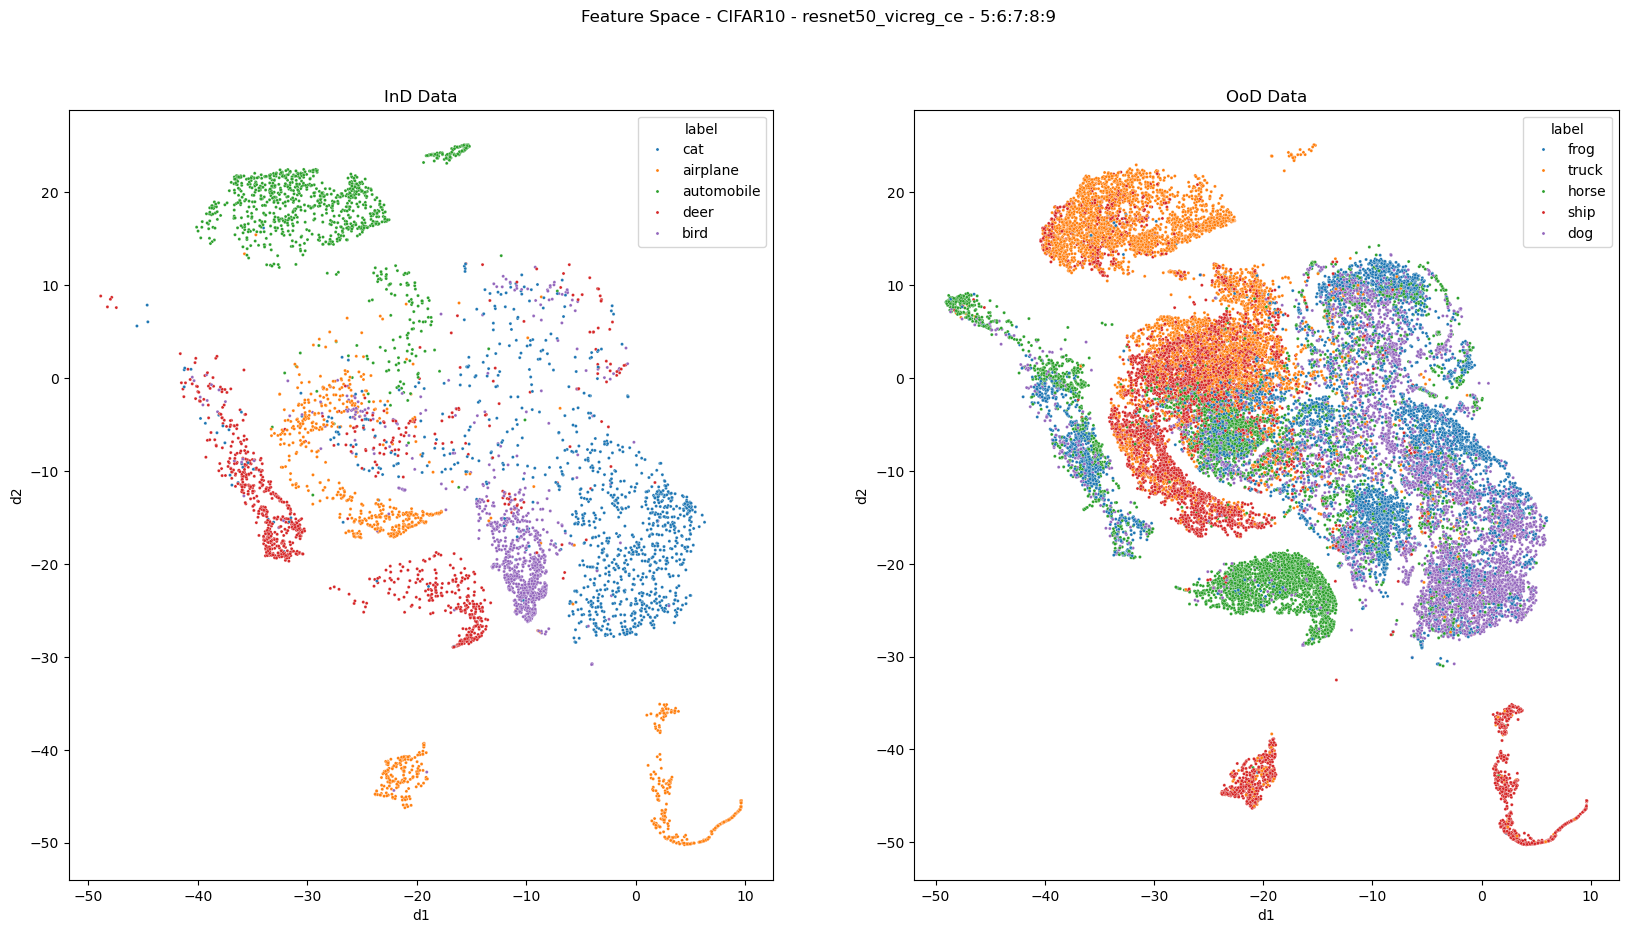

In [12]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

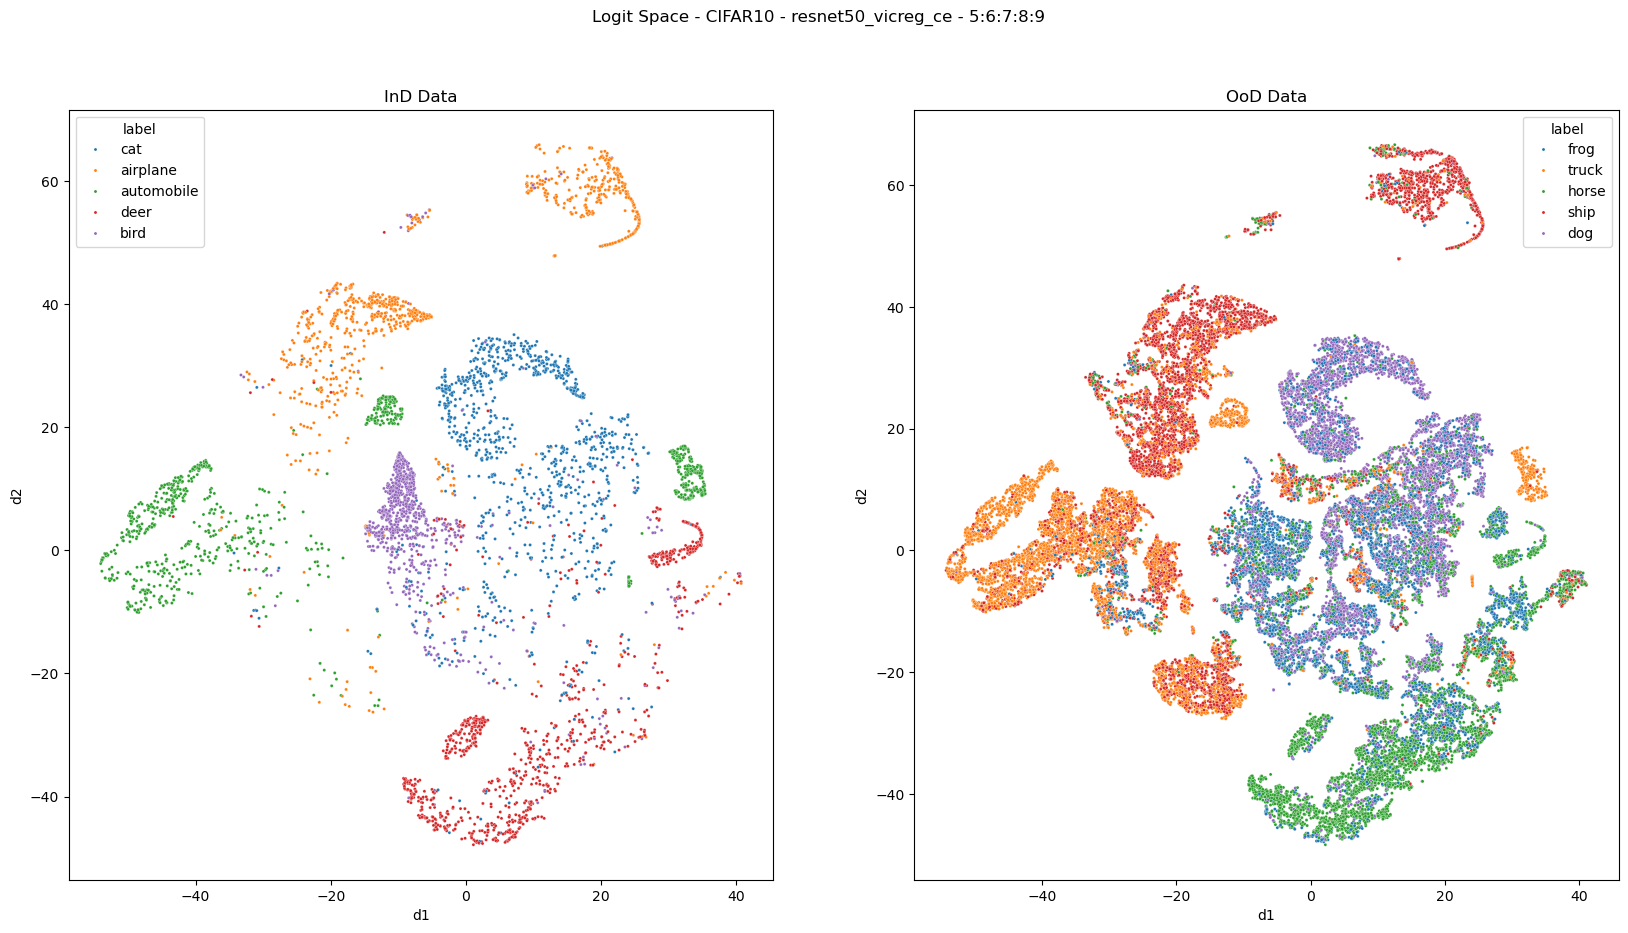

In [13]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:04<00:13,  4.52s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:09<00:09,  4.53s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:13<00:04,  4.57s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.65s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.61s/it]

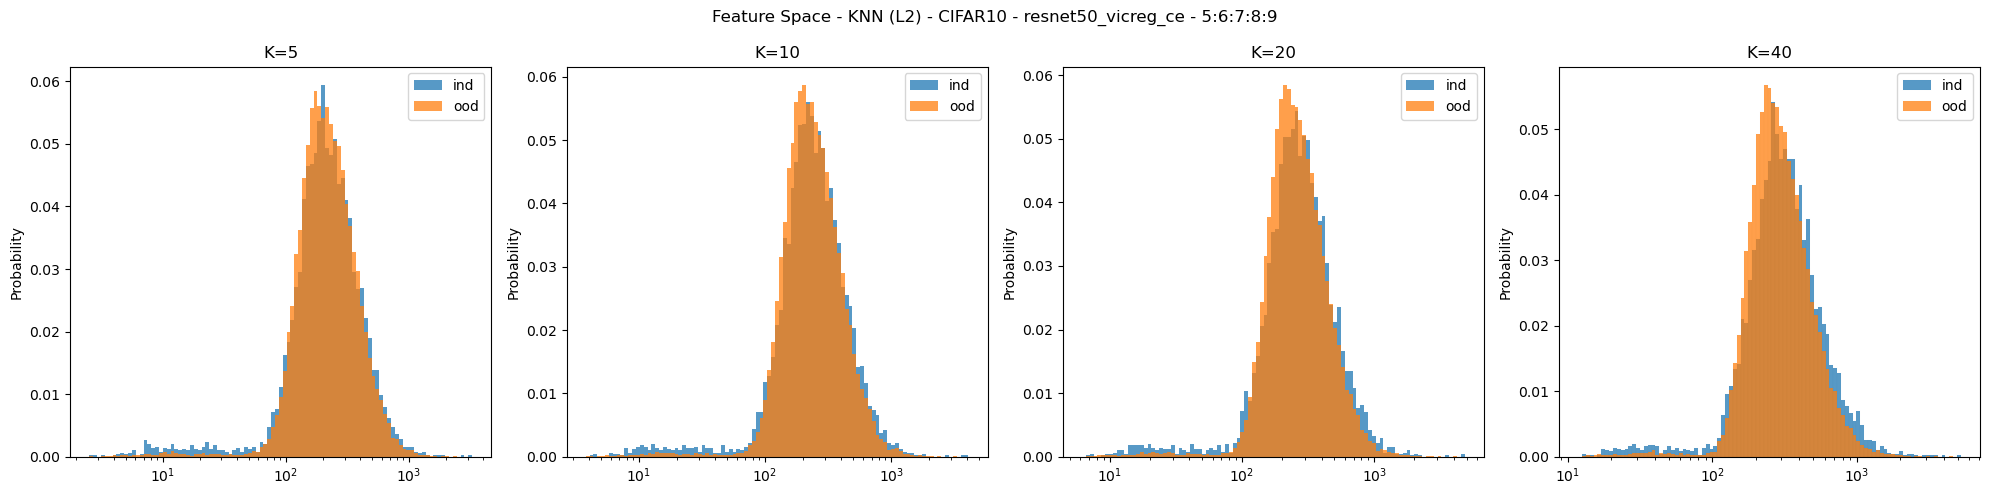

In [14]:
# plot knn to val data in feature space (L2)
index = faiss.IndexFlatL2(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:04<00:13,  4.47s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:09<00:09,  4.59s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:13<00:04,  4.58s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.64s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.61s/it]

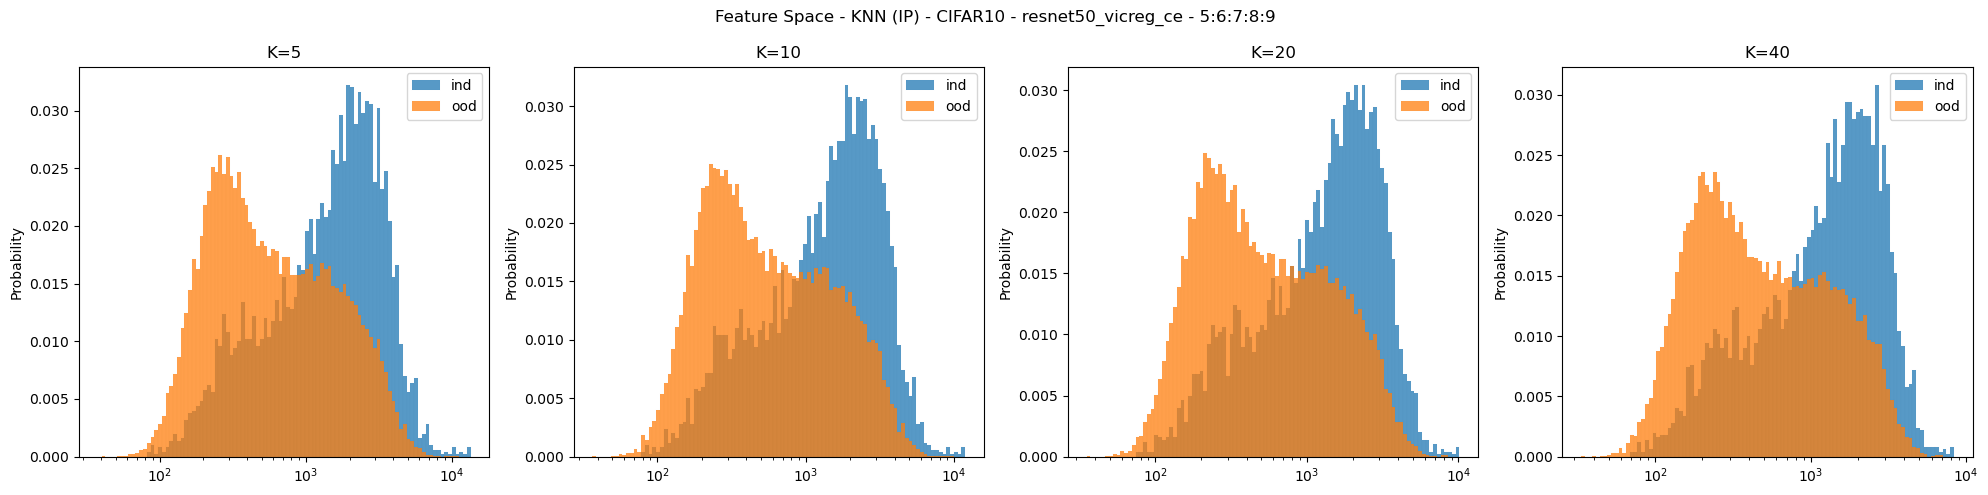

In [15]:
# plot knn to val data in feature space (IP)
index = faiss.IndexFlatIP(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:00<00:00,  3.36it/s]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:00<00:00,  3.16it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:01<00:00,  2.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]

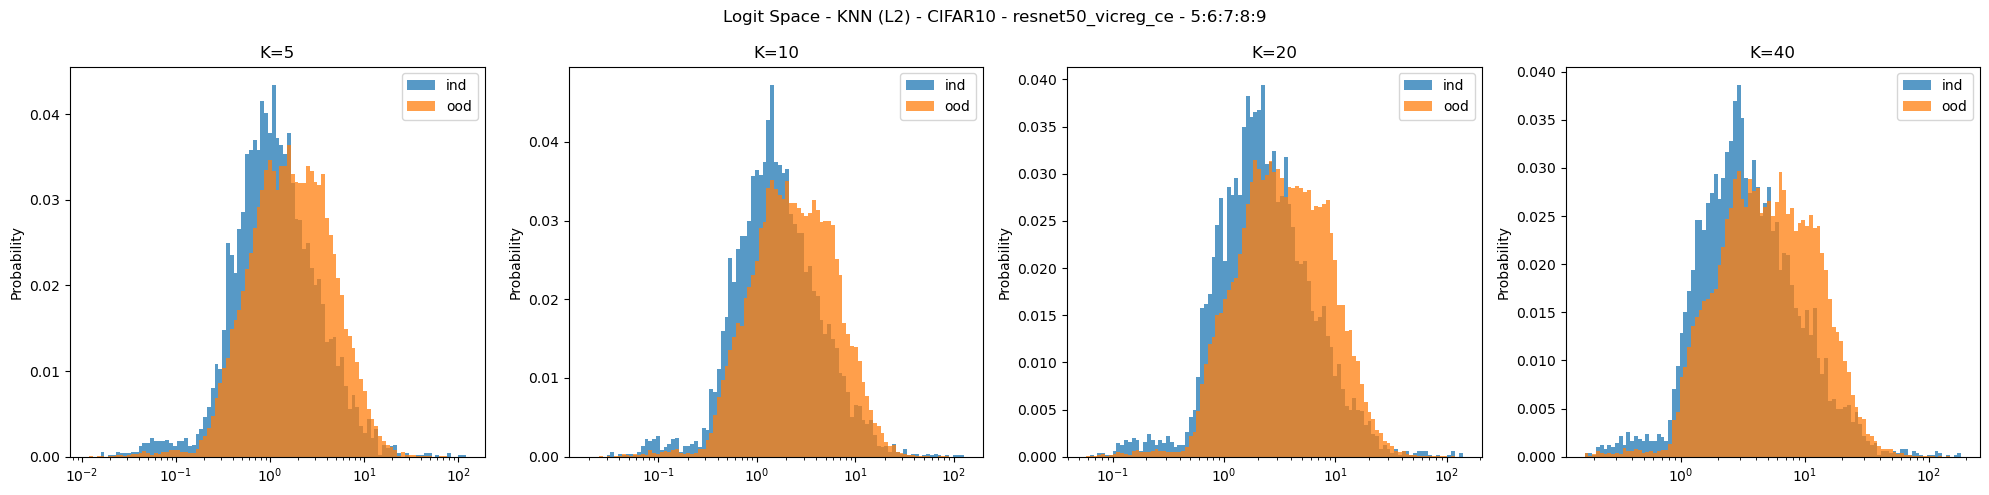

In [16]:
# plot knn to val data in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:00<00:00,  3.69it/s]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:00<00:00,  3.43it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:00<00:00,  2.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.65it/s]

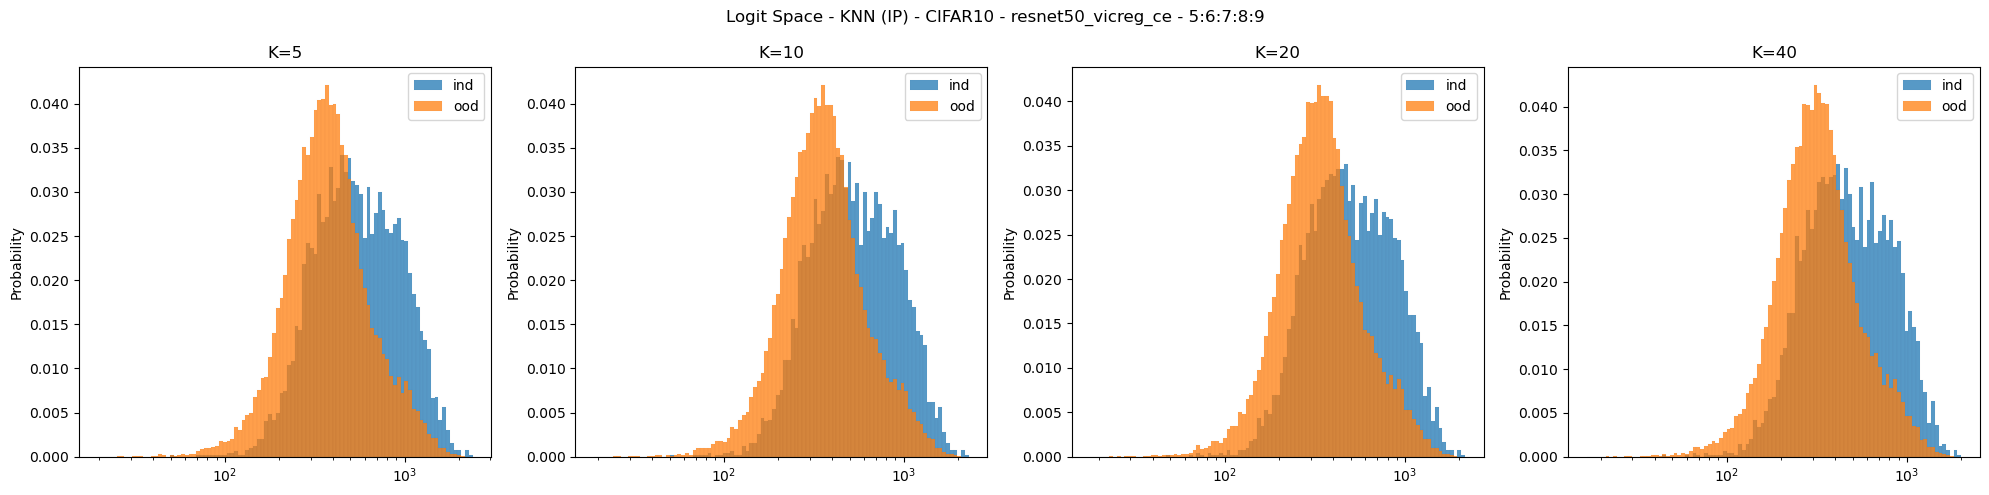

In [17]:
# plot knn to val data in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

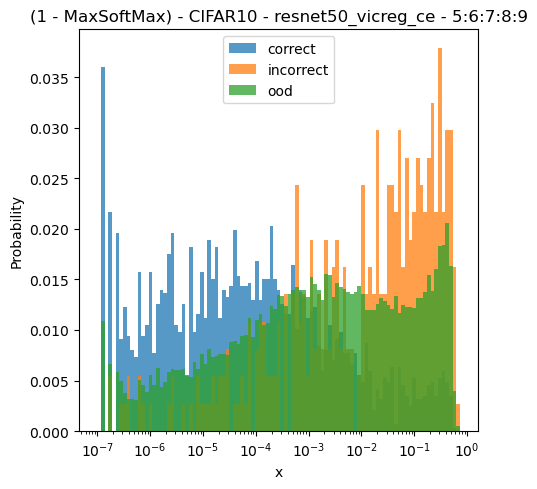

In [18]:
# plot (1 - maxsoftmax) distribution
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()